In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
sns.set(rc={'figure.figsize':(24, 12)})


In [2]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression as LinR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy

## Импорт данных

In [3]:
df1 = pd.read_excel('final_206852.xlsx', sheet_name = '2300')
df2 = pd.read_excel('final_206991.xlsx', sheet_name = '2300')
df3 = pd.read_excel('final_103448.xlsx', sheet_name = '2300')

In [4]:
df = pd.concat([df1,df2, df3])

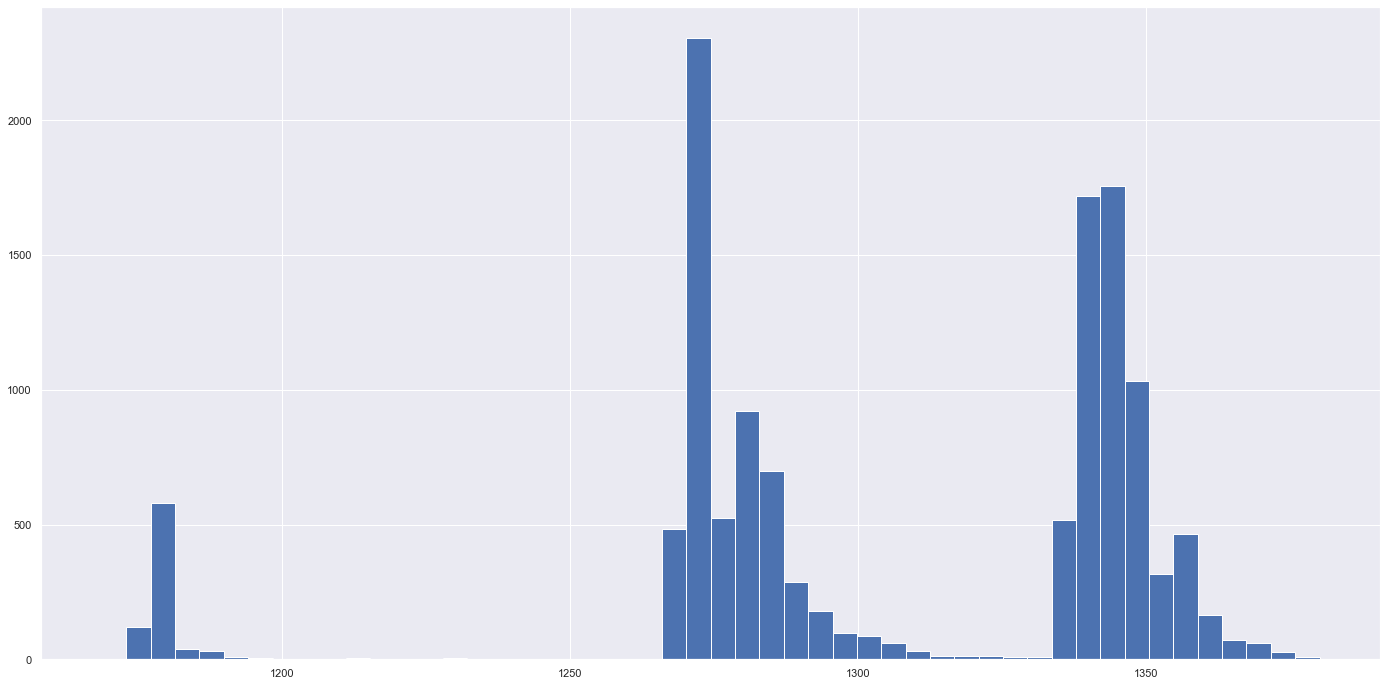

In [5]:
# Распределение ширины проката
df['Ширина'].hist(bins=50)

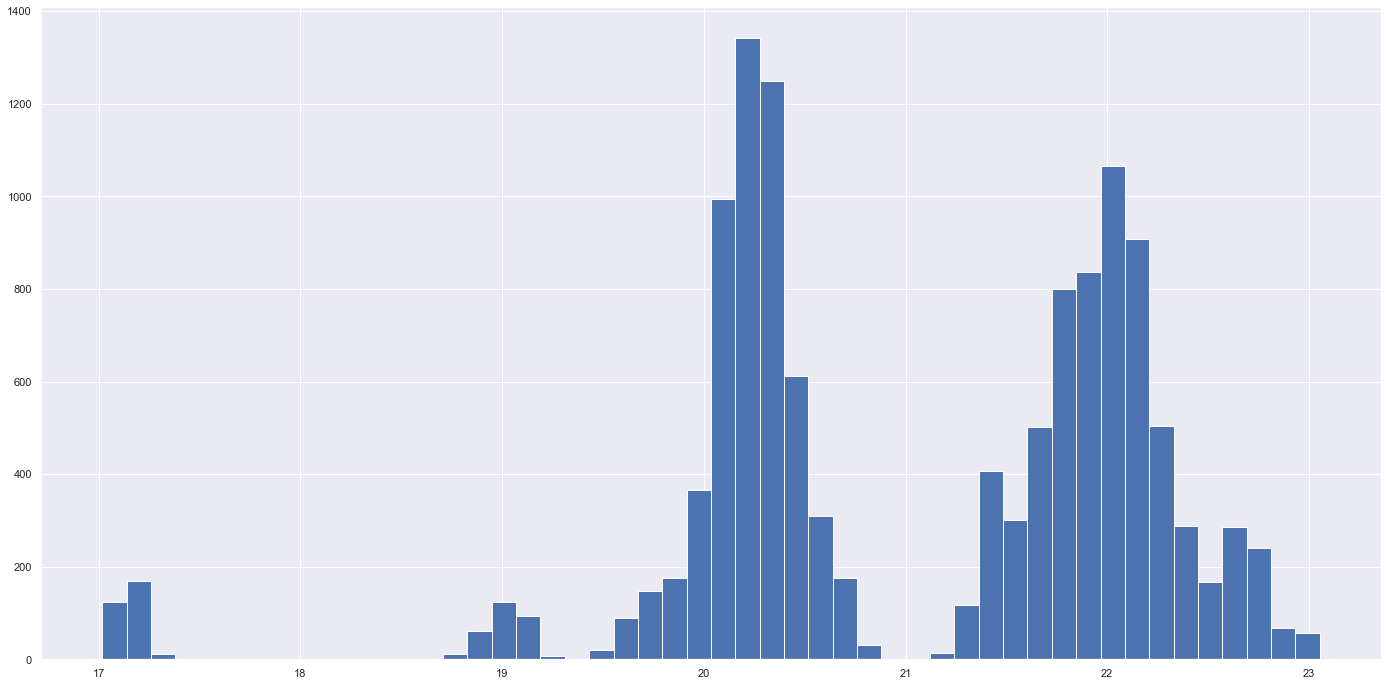

In [6]:
df['Толщина в центре'].hist(bins=50)

In [7]:
df.isnull().sum()

Номер рулона                          0
Начало прокатки                       0
Отступ                                0
Толщина в центре                      0
Разнотолщинность в центре             0
Температура в центре                  0
Ширина                                0
Утяжка                                0
Плавка                              258
Отступ.1                            258
Отклонение оси                      258
Средняя толщина                     258
Размах толщины                      258
Толщина в центре полосы             258
Разнотолщинность в центре полосы    258
dtype: int64

In [8]:
numeric_cols = ['Отступ', 'Толщина в центре', 'Ширина', 'Разнотолщинность в центре']

In [9]:
X = df[numeric_cols]
y = df['Утяжка']

In [10]:
# Масштабирование признаков
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

In [11]:
print(X_scaled[6])

[-1.54607874 -3.3173961   1.41523362 -1.58382994]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.33, random_state = 0)

In [13]:
print(sum(y_train == 0), sum(y_train == 1))
print(sum(y_test == 0), sum(y_test == 1))

5551 2940
2731 1452


## Логистическая регрессия

In [14]:
def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'],
                      optimizer.cv_results_['mean_test_score'][i],
                      optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2],
                     scores[:,1]+scores[:,2], alpha=0.3)
    plt.title('label')
    plt.show()

In [15]:
params_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 1000]}
cv = 5

In [16]:
estimator = LR(penalty = 'l2', class_weight = 'balanced', n_jobs=4)
optimizer = GridSearchCV(estimator, params_grid, scoring = 'accuracy', cv=cv)

In [17]:
optimizer.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=4, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [18]:
print(y_test[:10])
print(optimizer.predict(X_test)[:10])

2996    0
3775    1
371     0
5036    0
1846    0
3347    1
2062    0
2825    0
710     0
77      1
Name: Утяжка, dtype: int64
[1 1 1 0 1 1 1 1 1 1]


In [19]:
roc_auc = roc_auc_score(y_test, optimizer.predict_proba(X_test)[:,1])
print(roc_auc)

0.8905286512473358


In [20]:
optimizer.best_params_

{'C': 0.01}

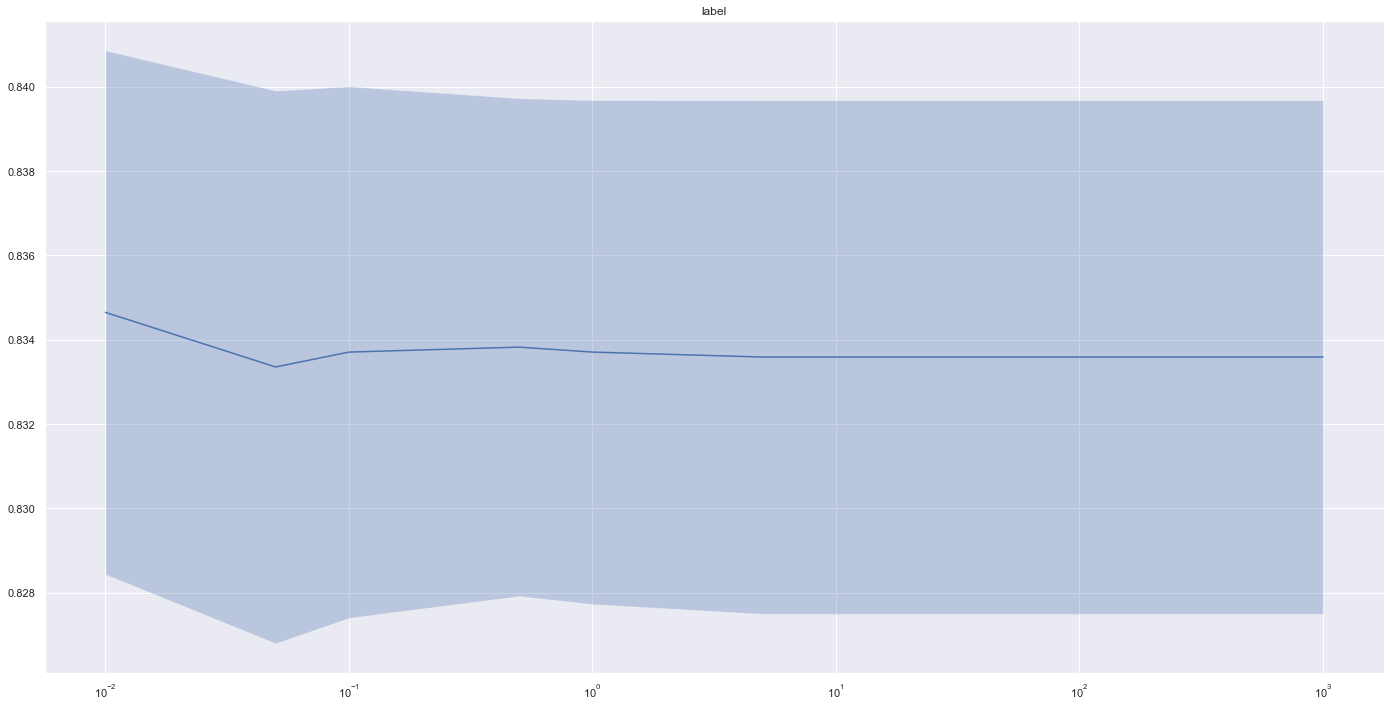

In [21]:
plot_scores(optimizer)

In [22]:
optimizer.best_estimator_.coef_

array([[ 0.1639433 ,  0.64010094, -1.29090016,  1.05864285]])

In [23]:
optimizer.best_estimator_

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=4, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
cross_val_score(optimizer, X_train, y_train, cv=cv).mean()

0.8346488026283042

In [25]:
y_pred = optimizer.predict(X_test)

In [26]:
accuracy_score(y_test, y_pred)

0.8183122161128377

## Решающие деревья


In [42]:
rfc = RandomForestClassifier(n_estimators=100)

In [48]:
params_grid_rfc = {'criterion': ['entropy', 'gini'], 'max_depth':[2, 4, 8]}
cv = 2

In [49]:
optimizer_rfc = GridSearchCV(rfc, params_grid_rfc, cv=cv)

In [50]:
# Обучение модели
optimizer_rfc.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [51]:
optimizer_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
cross_val_score(optimizer_rfc, X_train, y_train, cv=cv).mean()

0.895890124815041

In [53]:
cross_val_score(optimizer_rfc, X_test, y_test, cv=5).mean()

0.8895594313251358

In [56]:
y_tree_pred = optimizer_rfc.predict(X_test)

## Сравнение результатов

In [57]:
print(accuracy_score(y_test, y_tree_pred))
print(accuracy_score(y_test, y_pred))

0.8921826440353813
0.8183122161128377


In [58]:
print(precision_score(y_test, y_tree_pred))
print(precision_score(y_test, y_pred))

0.8177777777777778
0.6581352833638026


In [59]:
print(recall_score(y_test, y_tree_pred))
print(recall_score(y_test, y_pred))

0.8870523415977961
0.9917355371900827


In [60]:
f1_RF = (2 * precision_score(y_test, y_tree_pred) * recall_score(y_test, y_tree_pred)) / (precision_score(y_test, y_tree_pred) + recall_score(y_test, y_tree_pred))
f1_LR = (2 * precision_score(y_test, y_pred) * recall_score(y_test, y_pred)) / (precision_score(y_test, y_pred) + recall_score(y_test, y_pred))

In [61]:
print(f1_RF)
print(f1_LR)

0.8510075982821275
0.7912087912087913


In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      2731
           1       0.66      0.99      0.79      1452

    accuracy                           0.82      4183
   macro avg       0.83      0.86      0.82      4183
weighted avg       0.88      0.82      0.82      4183



In [63]:
print(classification_report(y_test, y_tree_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92      2731
           1       0.82      0.89      0.85      1452

    accuracy                           0.89      4183
   macro avg       0.88      0.89      0.88      4183
weighted avg       0.90      0.89      0.89      4183



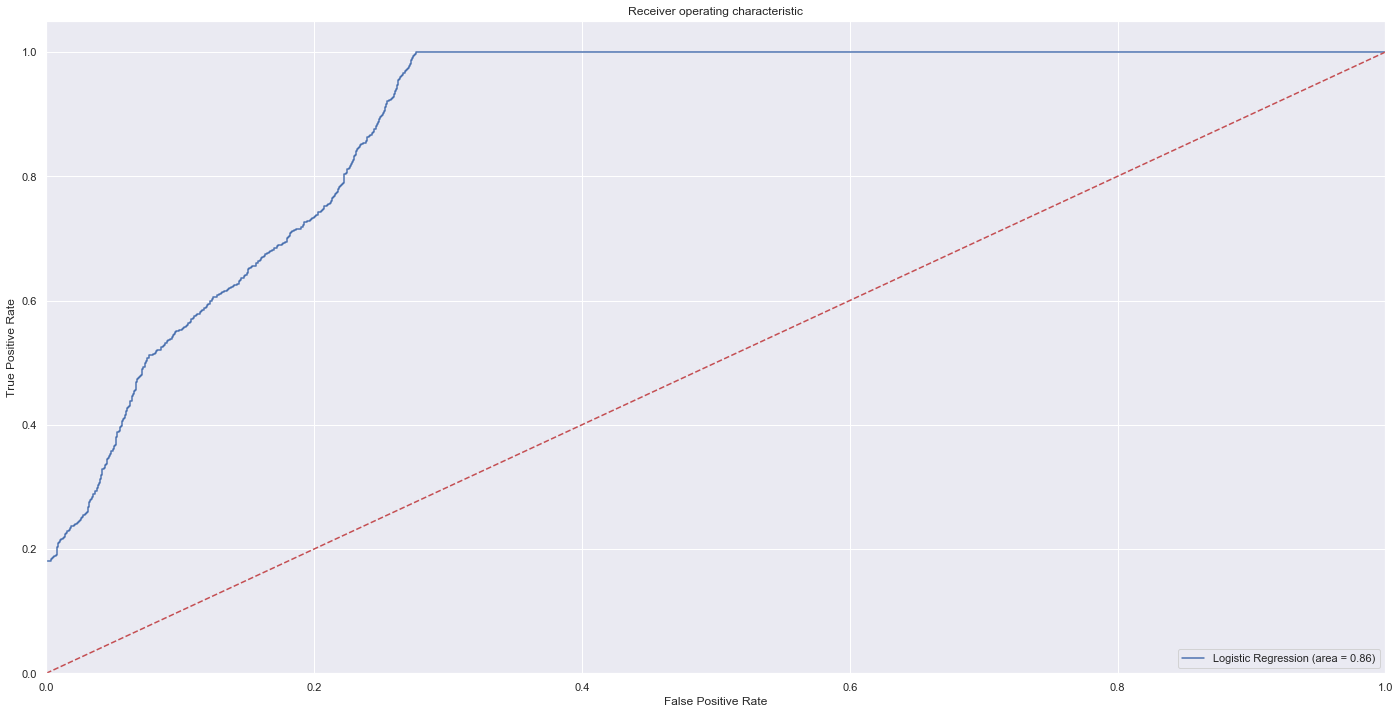

In [64]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, optimizer.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, optimizer.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

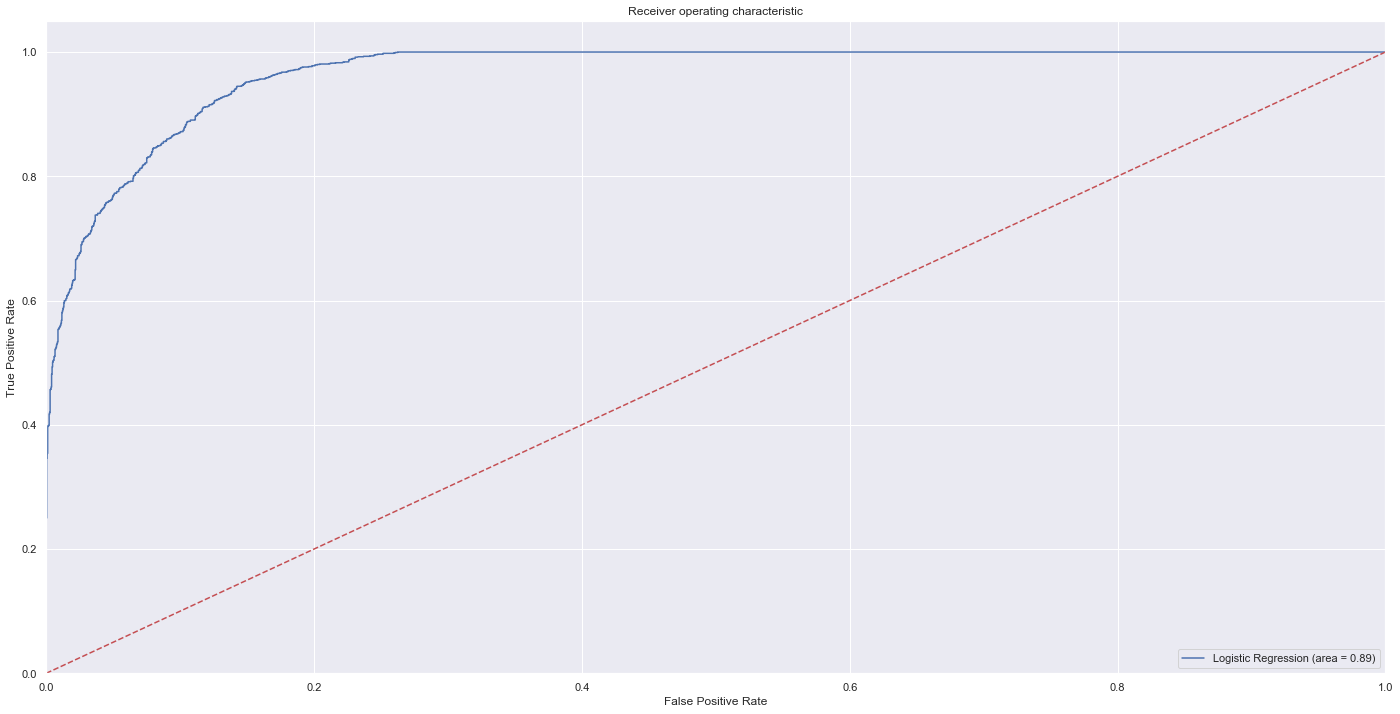

In [66]:
logit_roc_auc = roc_auc_score(y_test, optimizer_rfc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, optimizer_rfc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Сравнение результатов логистической регресии при изменении границы

In [67]:
y_pp = np.where(optimizer.predict_proba(X_test)[:,1] > 0.6, 1, 0)

In [68]:
print(precision_score(y_test, y_pp))
print(precision_score(y_test, y_pred))

0.6574766355140187
0.6581352833638026


In [69]:
print(recall_score(y_test, y_pp))
print(recall_score(y_test, y_pred))

0.96900826446281
0.9917355371900827


In [70]:
f1_LR = (2 * precision_score(y_test, y_pp) * recall_score(y_test, y_pp)) \
        / (precision_score(y_test, y_pp) + recall_score(y_test, y_pp))

In [71]:
f1_LR

0.7834075723830736